In [89]:
import pickle
from collections import OrderedDict
import scipy.stats
from pylab import * 
import seaborn as sns
from skbio.sequence import DNA
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"

In [90]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [91]:
NMER = 5

In [92]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
#     "hmm_params_out": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_hmm_params_{0}mer.pickle".format(NMER)
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
    "hmm_params_out": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_hmm_params_{0}mer.pickle".format(NMER)
}

In [93]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [94]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


### make dict with all kmers 

In [95]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

# Analysis

### compare with distributions in sequence

* kmer-frequence
* length (how many kmers were mapped correctly, at all) 

In [96]:
kmer_freq = OrderedDict((k, 0) for k in all_5mers)
for i in range(0, len(ref)-(NMER-1)):
    kmer_freq[ref[i:i+NMER]] += 1

In [97]:
true_kmer_freq = OrderedDict((k, len(v)) for k, v in ev_map.items())

In [98]:
scipy.stats.pearsonr(list(true_kmer_freq.values()), list(kmer_freq.values()))

(0.90596134938372408, 0.0)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


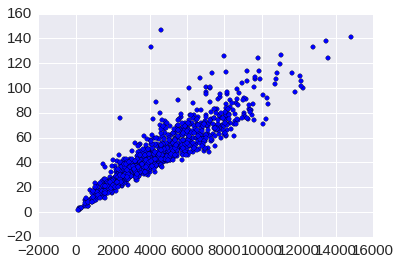

In [99]:
fig, ax = subplots()
ax.scatter(list(true_kmer_freq.values()), list(kmer_freq.values()))
fig.show()

#### outliers = kmers that are difficult to predict

### => Result

* there is a pretty strong correlation (pearson r = .9) between the frequency of kmers in the reference and the frequency of correctly predicted kmers
    * however there are some outliers
   

## compare features

In [100]:
def sorted_boxplot(ordered_dict):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    map2 = OrderedDict(sorted(ordered_dict.items(), key=lambda x : 0 if len(x[1]) == 0 else np.mean(x[1])))
    fig, ax = subplots(figsize = (15, 5))
    boxplot(list(map2.values()))
    ax.set_xticklabels(list(map2.keys()), rotation=90, fontsize=8)
    fig.show()

In [101]:
def make_feature_map(process_event, ev_map):
    """
    Args:
        process_events: function(strand, event) with 
            strand in ["template", "complement"] and 
            event containing the event features
        ev_map: dict kmer -> list of correct events
            
    Returns: 
        dict kmer -> list_with_features
    """
    fmap = {kmer: [] for kmer in ev_map.keys()}
    for kmer, events in ev_map.items():
        kmer_c = str(DNA(kmer).reverse_complement())
        d = {"template" : [], "complement" : []}
        for ev in events: 
            for t in d.keys():
                feature = process_event(t, ev)
                if not np.isnan(feature): 
                    d[t].append(feature)

        fmap[kmer].extend(d["template"])
        fmap[kmer_c].extend(d["complement"])
    return fmap

### mean pA

In [102]:
def feature_pa(t, ev): 
    return ev["{0}.mean".format(t)]

pa_map = make_feature_map(feature_pa, ev_map)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


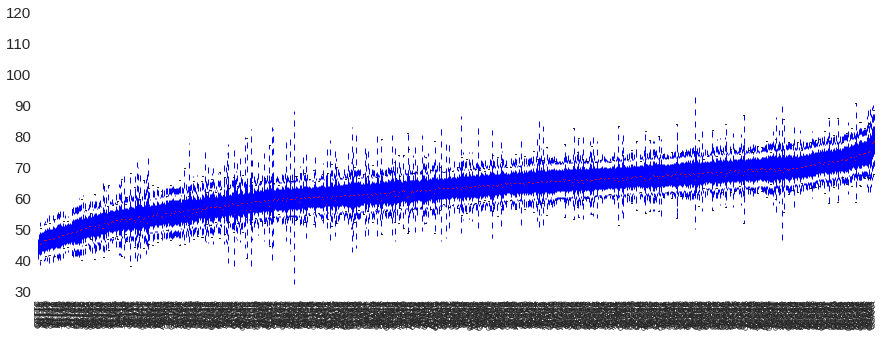

In [103]:
sorted_boxplot(pa_map)

### mean stdev

In [104]:
def feature_stdv(t, ev): 
    return ev["{0}.stdv".format(t)]

stdv_map = make_feature_map(feature_stdv, ev_map)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


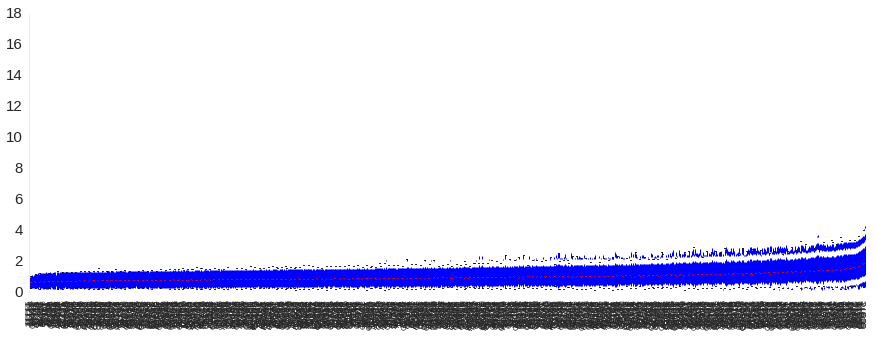

In [105]:
sorted_boxplot(stdv_map)

### mean length

In [106]:
def length_feature(t, ev):
    l, r = ev["{0}.start".format(t)], ev["{0}.end".format(t)]
    try:
        return r-l
    except: 
        return None

len_map = make_feature_map(length_feature, ev_map)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


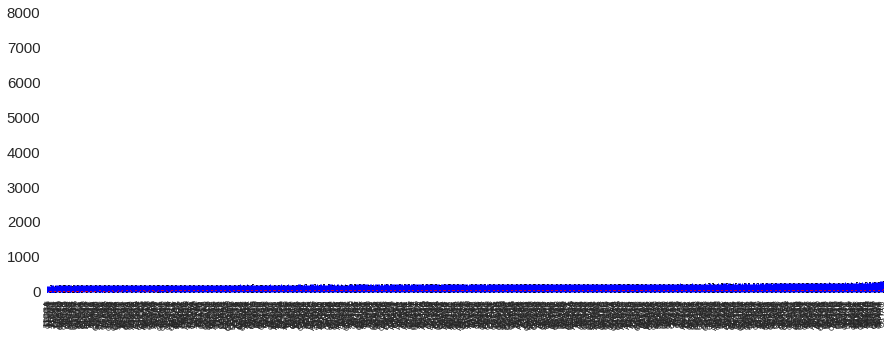

In [107]:
sorted_boxplot(len_map)

## outputs for hmm

In [108]:
means = []
stdv = []
kmers = []
for kmer, kmer_means in pa_map.items():
    kmers.append(kmer)
    means.append(np.mean(kmer_means))
    stdv.append(np.std(kmer_means))
    
hmm = {"means": means, "stdv": stdv, "kmers": kmers}

In [109]:
pickle.dump(hmm, open(args["hmm_params_out"], 'wb'), protocol=2)